Daniel Shackelford

CSPB3202 FinalProject

Github:

https://github.com/dash6877/CSPB3202FinalProject

Video:

    Non-Trained Model:
    https://gifyu.com/image/tyut
    
    Trained Model:
    https://gifyu.com/image/tyuO

***Short overview:***

For my final project, I decided to analyze the LunarLander-v2 gym environment using a Deep Q Network. The Lunar Lander task is centered around making movements to land a space ship inside of a designated area. The Lunar Lander receives rewards based on how close to the landing pad the lander gets without crashing. 

The goal of this specific project and implementation is to find a solution to the model in as few episodes as possible. The environment was tested with a general random approach and then tested again using a deep Q network. After implementing the network, it was also optimized. 



In [12]:
#import libraries
import gym
import random
import torch
import torch.nn as nn #neural networks
import torch.nn.functional as Functional 
import torch.optim as optim
import numpy as np

from IPython.display import Image

from collections import namedtuple, deque #stack
import matplotlib.pyplot as plt

%matplotlib inline

In [13]:
#Initialize
env=gym.make('LunarLander-v2')
env.seed(1)

[1]

***Approach:***

The state of the environment has 8 continuous values that represent the position of the lander in the x,y space, its velocity, angular speed, orientation, and other. There are 4 actions associated with the lander, these being: do nothing, fire left rocket, fire main rocket, and fire right rocket. The landing pad will always be at coordinates (0,0). Rewards for moving from the top of the screen to the bottom of the screen and at a speed of 0 is from 100-140. The amount of this reward is directly proportional to how close the lander is to the landing pad. The lander is given a +10 value for each leg that is on the ground, and firing the main engine incurs a reward of -0.3. The amount of fuel is infinite over the entire simulation. From a solutions standpoint the main engine firing penalty is an order of magnitude smaller than any of the rewards so, in general, a model that fires the main engine a lot is not necessarily a 'bad' solution. 

In the end, a deep q-learning network was selected for analysis of the system. The gym environment provides us with a number of states and actions. When the action space is discrete and the state space is continuous, DQN's work incredibly well. DQN's are also especially suited to overcome unstable learning using techniques like experience replay and target networks. The network used in this project was a Q network that included 3 fully connected layers, 'l1' being the input layer that takes in a tensor of our state size and outputs a tensor that is the size of the hidden nodes. The 'l3' layer takes an input of our hidden nodes and outputs a tensor that is the size of our action space. This outputs an action for each possible action that our agent can take. Torch also requires a forward method for the neural network library. The foward method takes in a tensor 'x' that is equal to the game state the agent is observing. This gets passed through the first layer of the neural network and we apply the ReLU activation function. We then do the same thing with the second layer. Then that value gets passed into the third layer as the output of the whole network. The forward method in torch is automatically used when data is passed into the network. I attempted to implement dropout inside of the network, however it greatly reduced the rate at which the model is trained and the model, without dropout, did not exhibit signs of overfitting the data set.

The Agent in this solution utilizes two instances of the QNet object, one of which is a training set and one of which is a target set. In regards to action selection, the agent uses an epsilon-greedy algorithm to select actions. This is a straightforward algorithm and can be replaced in the future to increase efficiency. The main reason for this is the use of a soft update function. Soft update was initialized inside of the model as it is a recommended method for improving performance of our data set. The problem with standard Q learning is that at any given point in time in the analysis of the system, the current value and the goal state use the same network weights. Every time the system learns, the weight of the Q-network changes. Since the goal also changes, covnergence on a certain value becomes harder. To remedy this issue, we can create a separate network, called a target network. A target network maintains a fixed value during the learning process of the original Q-network, and then periodically resets the q-network to its original q-network value (This concept was taken from the deepmind paper listed below). The soft update allows for the target network to be updated bit by bit, frequently over the course of the simulation. The value 'tau' is used to control this change. This allows the target network to move slightly to the value of the Q-network. Because tao is small, the updates need to be frequent. Prior to running the model, another quick way to gain some extra performance is to utilize proper initialization parameters in our model. We will delve into which parameters helped the most over the course of testing in our results section.

The model is trained using the 'DQN' function, whereby it is given a certain number of episodes to test over, and the model tries to receive the largest reward. For the purposes of this project, the testing will essentially never reach the maximum number of episodes as long as the model we are using is 'good enough'. This is because we set a hard limit of the model to stop once we receive a mean value that is greater than 200 from the reward function. This is because a value of 200 is the value assigned in the simulation to a correct solution, so maximization beyond this hard cutoff is essentially pointless. 


In [14]:
print ("The state is of the form: ", env.observation_space.shape)
print ("The total number of actions: ", env.action_space.n)

The state is of the form:  (8,)
The total number of actions:  4


In [15]:
useCuda = torch.cuda.is_available()
device = torch.device("cpu")

In [16]:
#PARAMETERS:
bufferSize = int(100000) # replay buffer size
batchSize = 64 # minibatch size
gammaDF = 0.99 # discount factor
tau = 0.001 # for soft update
learningRate= 0.0005 # learning rate 

Note: The below cell of code is the cell that defines the overall structure of the network that was defined. Instances of dropout layer constraints can be seen commented out int he code. These are an example of some of the changes that were intended to benefit the speed and accuracy of our model, but ended up hindering out performance. More detail on this layout can be found in "Approach" section of this report.

In [17]:
class QNet(nn.Module):
    
    def __init__(self, stateSize, actionSize, seed):
        super(QNet, self).__init__()
        
        self.seed = torch.manual_seed(seed) #have to set seed generation for replication

        self.l1 = nn.Linear(stateSize, 64) # create three nn layers from torch and set dimensions (64 for layers)
#       self.dropout1 = nn.Dropout(p=0.1)
        self.l2 = nn.Linear(64, 64)
#       self.dropout2 = nn.Dropout(p=0.1)
        self.l3 = nn.Linear(64, actionSize) #output
    
    def forward(self, state): #standard torch setup
        x = self.l1(state)
#       x = self.dropout1(x)
        x = Functional.relu(x)
        x = self.l2(x)
#       x = self.dropout1(x)
        x = Functional.relu(x)
        action = self.l3(x)
        return action


Note: The below set of code is used to save and replay an experience in the course of testing our model. The most important function called out is the sample function that takes a batch of random samples from memory stack of size 'batchSize' and then assigns the associated intended values from it. 

In [18]:
class ReplayExperience:

    def __init__(self, actionSize, bufferSize, batchSize, seed): #init experience store object
        self.actionSize = actionSize #dimension of action
        self.memory = deque(maxlen=bufferSize) #stack mem with max buffer size
        self.batchSize = batchSize #size of training batch
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "nextState", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, nextState, done): #add to mem stack
        exp = self.experience(state, action, reward, nextState, done)
        self.memory.append(exp)
    
    def sample(self): #get a batch of experiences and assign var values
        experiences = random.sample(self.memory, self.batchSize) #from mem, grab batchSize number of items
        
        #get each of the vals in the experiences for the batch and return
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        nextStates = torch.from_numpy(np.vstack([e.nextState for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device) 
  
        return (states, actions, rewards, nextStates, dones)

    def __len__(self): 
        return len(self.memory)   

Note: The below set of code is used to create the Agent object that is the main class of our model. It is important to note both the softUpdate and initialization functions that are part of the local and target networks employed in our schema and talked about throughout this paper. These concepts were taken from the below websites, I would highly encourage them for additional background. 

https://greentec.github.io/reinforcement-learning-third-en/#soft-update-target-network

https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf

In [19]:
class Agent():
    def __init__(self, stateSize, actionSize, seed):
        self.stateSize = stateSize #state dimensions
        self.actionSize = actionSize #action dimensions
        self.seed = random.seed(seed) 

        # Q-Network
        self.qnetLocal = QNet(stateSize, actionSize, seed).to(device) #will test on local 
        self.qnetTarget = QNet(stateSize, actionSize, seed).to(device) #will save off target
        self.optimizer = optim.Adam(self.qnetLocal.parameters(), lr=0.0005) #optimize with Adam

        # Replay memory
        self.memory = ReplayExperience(actionSize, bufferSize, batchSize, seed)

    def step(self, state, action, reward, nextState, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, nextState, done)
        if len(self.memory) > batchSize:
            experiences = self.memory.sample()
            self.learn(experiences, gammaDF)


    def act(self, state, epsilon=0.): #return action for state
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetLocal.eval()
        action_values = self.qnetLocal(state)
        self.qnetLocal.train()
        # Epsilon-greedy action selection 

        if random.random() <= epsilon:    
            return random.choice(np.arange(self.actionSize))

        else:
            return np.argmax(action_values.cpu().data.numpy())

    def learn(self, experiences, gammaDF): #update value parameters using softUpdate 
        states, actions, rewards, nextStates, dones = experiences

        # Get max predicted Q values (for next states) from target model
        QNext = self.qnetTarget(nextStates).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Qtargets = rewards + (gammaDF * QNext * (1 - dones))
        # Get expected Q values from local model
        Qexpected = self.qnetLocal(states).gather(1, actions)

        # Compute loss
        loss = Functional.mse_loss(Qexpected, Qtargets)
        # Minimize the loss
        self.optimizer.zero_grad() #set gradients on Adam optimizer to zero
        loss.backward()
        self.optimizer.step()
        
        #update target
        self.softUpdate(self.qnetLocal, self.qnetTarget, tau)
        
    # SoftUpdate idea from: https://greentec.github.io/reinforcement-learning-third-en/#soft-update-target-network
    def softUpdate(self, localModel, targetModel, tau):
        for targetParam, localParam in zip(targetModel.parameters(), localModel.parameters()):
            
            targetParam.data.copy_(tau*localParam.data + (1.0-tau)*targetParam.data)

Note: The below cell shows an untrained agent attempting to complete the challenge. As you will see, there is zero input to the controls and the lander's score is mainly influenced by its starting position and vector.

In [20]:
#Untrained Agent
agent = Agent(8, 4, 0)
# watch an untrained agent
state = env.reset()
for i in range(3):
    state = env.reset()
    for j in range(500):
        action = agent.act(state)
        env.render()
        state, reward, done, _ = env.step(action)
        if done:
            break 
    env.close()

In [21]:
#Same as above, used to create a gif for submission--does not have to be run every time. 
from PIL import Image

agent = Agent(8, 4, 0)
# watch an untrained agent
state = env.reset()
frames=[]
for i in range(5):
    
    state = env.reset()
    for j in range(500):
        action = agent.act(state)
        frames.append(Image.fromarray(env.render(mode='rgb_array')))
        state, reward, done, _ = env.step(action)
        if done:
            break 
    env.close()

with open('./preTrain.gif', 'wb') as foo:
    im = Image.new('RGB', frames[0].size)
    im.save(foo, save_all=True, append_images=frames)

In [22]:
#Uncomment below to play gif of untrained model!

# with open('./preTrain.gif','rb') as f:
#     display(Image(data=f.read(), format='png'))


Note: The below cell shows the training of the DQN against our environment. As referenced in the rest of the paper, the model achieves a mean average reward above a value fo 200 for our environment in around 385 episodes. 

In [23]:
def DQN():
    totalPossibleEpisodes=1000
    epsilonDecay=0.995 #need to decrease epsilon until down for each episode
    eps = 0.9 # initialize epsilon
    
    scores = [] # list containing scores from each episode
    currentSet = deque(maxlen=100) # last 100 scores

    print('Starting DQN learning! \n')
    print('Episode:                Average Score: ')
    
    for i in range(1, totalPossibleEpisodes+1):
        state = env.reset()
        currScore = 0
        
        for t in range(1000):#1000 is the cut off for time steps allowed per episode
            action = agent.act(state, eps)
            nextState, reward, done, _ = env.step(action)
            agent.step(state, action, reward, nextState, done)
            state = nextState
            currScore += reward
            if done:
                break 
                
        currentSet.append(currScore) # save most recent score
        scores.append(currScore) # save most recent score
        eps = max(0.01, epsilonDecay*eps) # decrease epsilon
        
        if i % 100 == 0:
            print('\rEpisode: {} --------> Average Score: {:.2f}'.format(i, np.mean(currentSet)))
        if np.mean(currentSet)>=200.0: #check to see if success
            print('\nEnvironment solved in {:d} episodes! --------> Average Score: {:.2f}'.format(i, np.mean(currentSet)))
            torch.save(agent.qnetLocal.state_dict(), 'finalSolution.pth') #save the local qnet as final
            break
            
    return scores

scores = DQN()
#roughly 385 episodes

Starting DQN learning! 

Episode:                Average Score: 
Episode: 100 --------> Average Score: -121.51
Episode: 200 --------> Average Score: -71.37
Episode: 300 --------> Average Score: 78.48

Environment solved in 374 episodes! --------> Average Score: 201.35


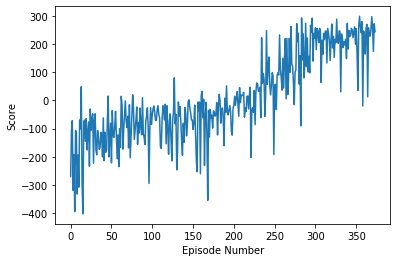

In [24]:
#create a plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode Number')
plt.show()

Note: Below shows a replay file of the trained model completeing our given task. Please note that the trained agent has reached a mean score that is over the 'winning' score of the environment, meaning that the agent should be winning in virtually all given scenarios. 

In [25]:
# load the weights from file
agent.qnetLocal.load_state_dict(torch.load('finalSolution.pth'))


for i in range(3):
    state = env.reset()
    for j in range(1000):
        action = agent.act(state)
        env.render()
        state, reward, done, _ = env.step(action)
        if done:
            break 
            
env.close()

In [26]:
#Same as above, used to create a gif for submission--does not have to be run every time. 
agent.qnetLocal.load_state_dict(torch.load('finalSolution.pth'))

frames2=[]
for i in range(5):
    state = env.reset()
    for j in range(1000):
        action = agent.act(state)
        frames2.append(Image.fromarray(env.render(mode='rgb_array')))
        state, reward, done, _ = env.step(action)
        if done:
            break 
            
env.close()

with open('./postTrain.gif', 'wb') as foo:
    im = Image.new('RGB', frames2[0].size)
    im.save(foo, save_all=True, append_images=frames2)

In [28]:
#Uncommment below to see gif of trained model
# with open('./postTrain.gif','rb') as f:
    
#     display(Image(data=f.read(), format='png'))

***Results:***

Over the course of creation of this model, multiple different neural networks were attempted. The original network that was created utilized multiple 2D convolutional layers inside of its architecture, however that model struggled with the continuous state of the model. 

The selected model has immediate benefit over other possible models as the tensor input and output of the linear model allows for better analysis of the continuous domain of the problem, as well as the RELU functions between layers. Once the model was created, it took a large amount of trial and error in order to ascertain the correct starting parameters, namely reducing the starting epsilon value, changing the learning rate, and altering epsilon decay. The most straighforward and fastest jump in performance seen during testing of this specific implementation was to lessen the starting epsilon value. Changes in the learning rate where more problematic as the model often failed to converge on a high enough value, a symptom of the learning curve being too steep.  

Once these changes had been implemented the model was run. The original model, without improvements, achieved a mean reward value above 200 in 787 episodes, and after improvements the new model achieved a mean reward value above 200 in 385 episodes. The reward for each episode in the set has been plotted above. It can be seen that although our reward per episode may be relatively noisy, the overall trend increases steadily over the course of the testing. Of note, we can see a slight leveling off of the reward increase from 150-275 episodes and again after 325 episodes. There is also a sharp increase between 275 and 325. 

***Conclusion:***

Overall this project went well. The most difficult part of the entire project was learning how to properly implement an agent using pyTorch and doing research on DQNs and how they are implemented. I have listed the references my resources below, of particular note is the paper by deepmind that also uses many of these techniques. Moving forward in the project, I would like to implement a Double-deep q-learning network. David Silver of Deepmind pointed out that DDQN is one of the major improvements made since Nature DQN. DDQN does not suffer as much from an inherent issue with Q learning, the tendency for overestimation fo q-values. I think that this implementation would be very interesting to compare to the standard DQN solution found above. In conclusion, this project was incredibly informative and lead to me receiving a huge amount of knowledge in current RL algorithms and how they are used. I am excited that I had the opportunity to learn pyTorch and its applications and I had a lot fo fun implementing this simulation.  

REFERENCED MATERIAL:

http://seba1511.net/tutorials/intermediate/reinforcement_q_learning.html

https://greentec.github.io/reinforcement-learning-third-en/#soft-update-target-network

https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf

https://arxiv.org/abs/1509.06461

https://arxiv.org/abs/1511.06581

https://arxiv.org/abs/1511.05952

https://medium.com/coinmonks/landing-a-rocket-with-simple-reinforcement-learning-3a0265f8b58c